In [ ]:
#Step 1. Imports and Data Loading
from google.colab import drive
drive.mount('/content/drive')
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
# Please ensure you upload the files in Colab and update the paths accordingly.
# For example, replace 'path_to_revenue_data.csv' with the path to your revenue dataset file
# and 'path_to_usage_data.csv' with your usage dataset file path.

# Load the dataset
revenue_data = pd.read_csv('/content/drive/My Drive/Datasets/FraudFinder Case Study - Monthly Customer Revenues Data Set.csv')
usage_data = pd.read_csv('/content/drive/My Drive/Datasets/FraudFinder Case Study - Maximum Monthly Usage Data Set.csv')

Mounted at /content/drive


In [ ]:
# Step 2: Data Cleaning for Revenue Data
# Clean the revenue data by removing any non-numeric characters and converting columns to numeric
# This will ensure we can perform calculations on revenue values

# Remove symbols like '$' and convert columns to numeric where possible, handling '-' values as NaN
for col in revenue_data.columns[2:]:
    revenue_data[col] = revenue_data[col].replace('[\$, -]', '', regex=True).replace('', None).astype(float)

# Confirm the cleaning was successful by checking data types and displaying sample data
revenue_data.info()
revenue_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5249 entries, 0 to 5248
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cust_ID        5247 non-null   object 
 1   Product Group  5247 non-null   object 
 2   1/2021         3929 non-null   float64
 3   1/2022         3591 non-null   float64
 4   1/2023         3187 non-null   float64
 5   1/2024         3014 non-null   float64
dtypes: float64(4), object(2)
memory usage: 246.2+ KB


,Cust_ID,Product Group,1/2021,1/2022,1/2023,1/2024
0,CUSTOMER 1,FraudFinder 2.0.,172.0,198.0,218.0,240.0
1,CUSTOMER 10,FraudFinder,81.0,NaN,NaN,NaN
2,CUSTOMER 100,FraudFinder 2.0.,68.0,68.0,74.0,82.0
3,CUSTOMER 1000,FraudFinder,81.0,122.0,NaN,NaN
4,CUSTOMER 1001,FraudFinder,81.0,101.0,NaN,NaN


In [ ]:
# Step 3. Data Cleaning for Usage Data

# Clean the usage data by removing commas and converting the transaction count to numeric
# This will allow calculations of engagement trends based on the number of transactions

# Remove commas and any remaining non-numeric characters, including handling different variations of '-'
usage_data['# Transactions'] = usage_data['# Transactions'].replace(r'[\s,-]+', '', regex=True).replace('', None).astype(float)

# Confirm cleaning was successful by checking data types and displaying sample data
usage_data.info()
usage_data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5248 entries, 0 to 5247
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            5248 non-null   int64  
 1   Cust_ID         5248 non-null   object 
 2   # Transactions  4321 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 123.1+ KB


,Year,Cust_ID,# Transactions
0,2021,CUSTOMER 3,103.0
1,2021,CUSTOMER 4,26827.0
2,2021,CUSTOMER 8,2211549.0
3,2021,CUSTOMER 9,50023.0
4,2021,CUSTOMER 11,2074955.0


In [ ]:
#############################
#############################    2

# Step 1: Identify Migrated Customers
migrated_customers = revenue_data.groupby('Cust_ID')['Product Group'].nunique()
migrated_customers = migrated_customers[migrated_customers > 1].index.tolist()

# Filter data for these migrated customers
migration_data = revenue_data[revenue_data['Cust_ID'].isin(migrated_customers)]
migration_data_sorted = migration_data.sort_values(by=['Cust_ID', 'Product Group'])

# Step 2: Separate FraudFinder and FraudFinder 2.0 data for these customers
fraudfinder_data = migration_data_sorted[migration_data_sorted['Product Group'] == 'FraudFinder']
fraudfinder2_data = migration_data_sorted[migration_data_sorted['Product Group'] == 'FraudFinder 2.0.']

# Calculate the average revenue per customer for each product group
fraudfinder_avg_revenue_per_customer = fraudfinder_data[['1/2021', '1/2022', '1/2023', '1/2024']].mean(axis=1)
fraudfinder2_avg_revenue_per_customer = fraudfinder2_data[['1/2021', '1/2022', '1/2023', '1/2024']].mean(axis=1)

# Step 3: Calculate overall average revenue for both product groups
average_revenue_before_migration = fraudfinder_avg_revenue_per_customer.mean()
average_revenue_after_migration = fraudfinder2_avg_revenue_per_customer.mean()

# Calculate revenue increase percentage
revenue_increase_percentage = ((average_revenue_after_migration - average_revenue_before_migration) / average_revenue_before_migration) * 100

# Print the results
print(f"Average Revenue Before Migration (FraudFinder): ${average_revenue_before_migration:.2f}")
print(f"Average Revenue After Migration (FraudFinder 2.0): ${average_revenue_after_migration:.2f}")
print(f"Revenue Increase Due to Migration: {revenue_increase_percentage:.2f}%")


Average Revenue Before Migration (FraudFinder): $228.18
Average Revenue After Migration (FraudFinder 2.0): $541.57
Revenue Increase Due to Migration: 137.34%


In [ ]:
# Identify migrated customers who have both FraudFinder and FraudFinder 2.0 entries
migrated_customers = revenue_data.groupby('Cust_ID')['Product Group'].nunique()
migrated_customers = migrated_customers[migrated_customers > 1].index.tolist()

# Exclude these migrated customers from the churn analysis
churn_data = revenue_data[~revenue_data['Cust_ID'].isin(migrated_customers)].copy()

# Add churn flags for each year for customers who haven't migrated
churn_data['Churned_2022'] = churn_data['1/2021'].notna() & churn_data['1/2022'].isna()
churn_data['Churned_2023'] = churn_data['1/2022'].notna() & churn_data['1/2023'].isna()
churn_data['Churned_2024'] = churn_data['1/2023'].notna() & churn_data['1/2024'].isna()

# Calculate churned customers by product and year, excluding migrated customers
churn_summary_excluding_migrants = churn_data.groupby('Product Group')[['Churned_2022', 'Churned_2023', 'Churned_2024']].sum()
print("Churn Summary by Product Group and Year (Excluding Migrated Customers):")
print(churn_summary_excluding_migrants)



Churn Summary by Product Group and Year (Excluding Migrated Customers):
                  Churned_2022  Churned_2023  Churned_2024
Product Group                                             
FraudFinder                310           235           128
FraudFinder 2.0.           149           113           112
Other                        0             0             0


In [ ]:
# Define function to calculate revenue loss for true churned customers in a given year
def revenue_loss_due_to_churn_excluding_migrants(data, churn_column, revenue_column):
    churned_customers = data[data[churn_column] == 1]
    return churned_customers[revenue_column].sum()

# Calculate revenue loss for each year excluding migrated customers
revenue_loss_2022_excl_migrants = revenue_loss_due_to_churn_excluding_migrants(churn_data, 'Churned_2022', '1/2021')
revenue_loss_2023_excl_migrants = revenue_loss_due_to_churn_excluding_migrants(churn_data, 'Churned_2023', '1/2022')
revenue_loss_2024_excl_migrants = revenue_loss_due_to_churn_excluding_migrants(churn_data, 'Churned_2024', '1/2023')

print(f"Revenue Loss due to True Churn in 2022 (Excluding Migrants): ${revenue_loss_2022_excl_migrants:.2f}")
print(f"Revenue Loss due to True Churn in 2023 (Excluding Migrants): ${revenue_loss_2023_excl_migrants:.2f}")
print(f"Revenue Loss due to True Churn in 2024 (Excluding Migrants): ${revenue_loss_2024_excl_migrants:.2f}")


Revenue Loss due to True Churn in 2022 (Excluding Migrants): $83943.00
Revenue Loss due to True Churn in 2023 (Excluding Migrants): $73895.00
Revenue Loss due to True Churn in 2024 (Excluding Migrants): $72337.00


Column names in average_revenue_yearly: Index(['FraudFinder', 'FraudFinder 2.0.', 'Other'], dtype='object', name='Product Group')


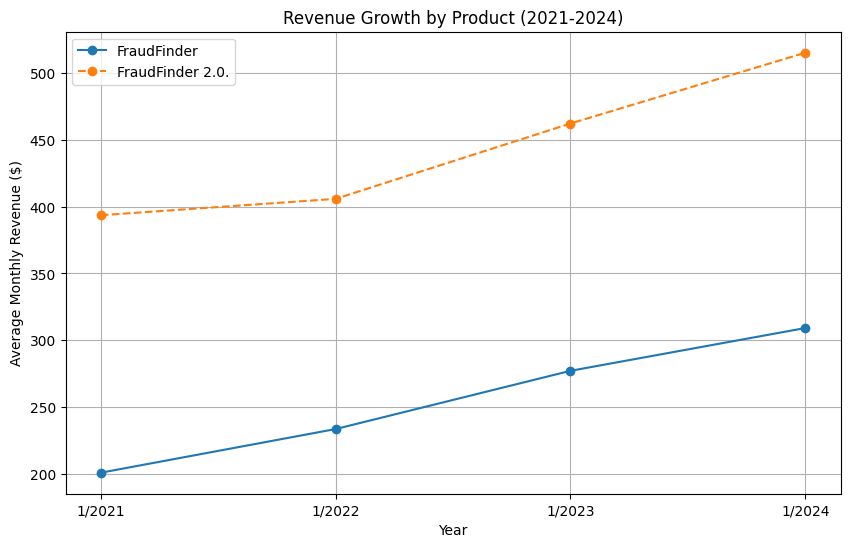

In [ ]:


# Slide 2: Revenue Growth Analysis
# 1. Calculate and Plot Revenue Growth by Product

# Check column names in average_revenue_yearly to confirm product group names
average_revenue_yearly = revenue_data.groupby('Product Group')[['1/2021', '1/2022', '1/2023', '1/2024']].mean().T
print("Column names in average_revenue_yearly:", average_revenue_yearly.columns)

# Plotting with exact column names (adjust names based on the output above if they differ)
import matplotlib.pyplot as plt

# Ensure product group names match exactly what is printed above
plt.figure(figsize=(10, 6))
plt.plot(average_revenue_yearly.index, average_revenue_yearly[average_revenue_yearly.columns[0]], marker='o', label=average_revenue_yearly.columns[0])
plt.plot(average_revenue_yearly.index, average_revenue_yearly[average_revenue_yearly.columns[1]], marker='o', linestyle='--', label=average_revenue_yearly.columns[1])
plt.title('Revenue Growth by Product (2021-2024)')
plt.xlabel('Year')
plt.ylabel('Average Monthly Revenue ($)')
plt.legend()
plt.grid(True)
plt.show()



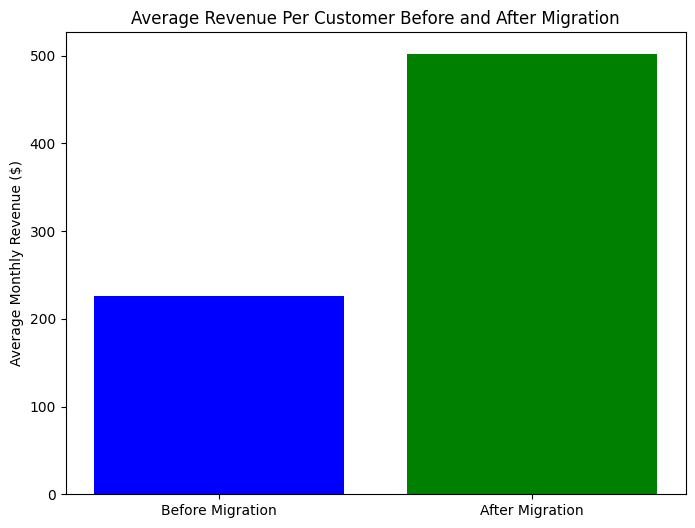

In [ ]:
#############################
#############################    2

# Slide 3: Customer Migration and Revenue Impact
# 1. Calculate Revenue Impact of Migration
# Step 1: Identify Migrated Customers
migrated_customers = revenue_data.groupby('Cust_ID')['Product Group'].nunique()
migrated_customers = migrated_customers[migrated_customers > 1].index.tolist()

# Filter data for these migrated customers
migration_data = revenue_data[revenue_data['Cust_ID'].isin(migrated_customers)]

# Step 2: Separate FraudFinder and FraudFinder 2.0 data and merge on 'Cust_ID'
fraudfinder_data = migration_data[migration_data['Product Group'] == 'FraudFinder'][['Cust_ID', '1/2021', '1/2022', '1/2023', '1/2024']]
fraudfinder2_data = migration_data[migration_data['Product Group'] == 'FraudFinder 2.0.'][['Cust_ID', '1/2021', '1/2022', '1/2023', '1/2024']]

# Renaming columns for easier differentiation
fraudfinder_data = fraudfinder_data.rename(columns={'1/2021': 'FF_2021', '1/2022': 'FF_2022', '1/2023': 'FF_2023', '1/2024': 'FF_2024'})
fraudfinder2_data = fraudfinder2_data.rename(columns={'1/2021': 'FF2_2021', '1/2022': 'FF2_2022', '1/2023': 'FF2_2023', '1/2024': 'FF2_2024'})

# Merge the two datasets on 'Cust_ID'
merged_data = pd.merge(fraudfinder_data, fraudfinder2_data, on='Cust_ID', how='inner')

# Step 3: Calculate average revenue before and after migration for each customer
merged_data['Avg_Revenue_Before'] = merged_data[['FF_2021', 'FF_2022', 'FF_2023', 'FF_2024']].mean(axis=1)
merged_data['Avg_Revenue_After'] = merged_data[['FF2_2021', 'FF2_2022', 'FF2_2023', 'FF2_2024']].mean(axis=1)

# Calculate revenue change per customer
merged_data['Revenue_Change'] = merged_data['Avg_Revenue_After'] - merged_data['Avg_Revenue_Before']
average_revenue_change = merged_data['Revenue_Change'].mean()

# Plotting the average revenue before and after migration for migrated customers
labels = ['Before Migration', 'After Migration']
values = [merged_data['Avg_Revenue_Before'].mean(), merged_data['Avg_Revenue_After'].mean()]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green'])
plt.title('Average Revenue Per Customer Before and After Migration')
plt.ylabel('Average Monthly Revenue ($)')
plt.show()


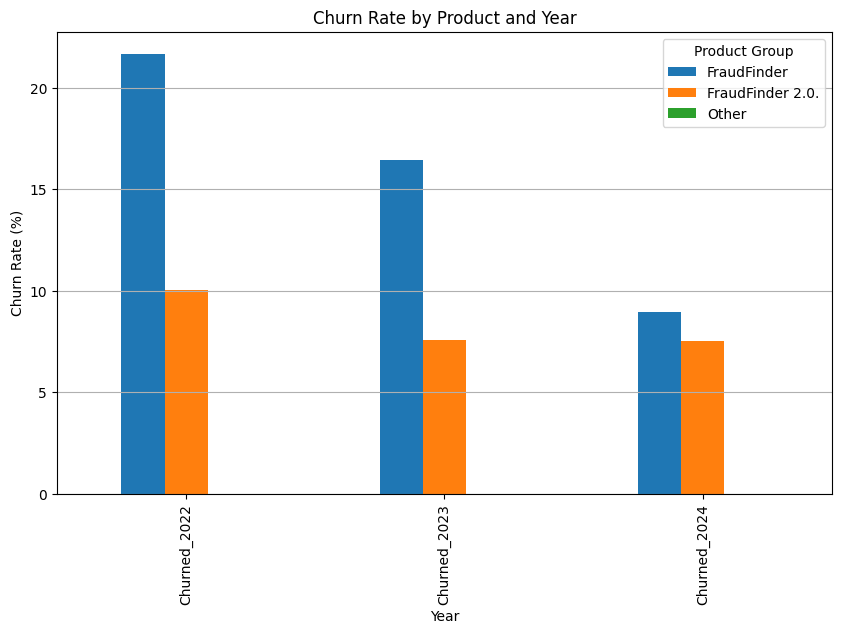

Revenue Loss due to Churn in 2022: $83943.00
Revenue Loss due to Churn in 2023: $73895.00
Revenue Loss due to Churn in 2024: $72337.00


In [ ]:
#############################
#############################    3

# Slide 4: Customer Retention and Churn Analysis
# 1. Calculate Churn Rate and Revenue Loss from Churn
# Exclude migrated customers for true churn analysis
churn_data = revenue_data[~revenue_data['Cust_ID'].isin(migrated_customers)].copy()

# Add churn flags for each year
churn_data['Churned_2022'] = churn_data['1/2021'].notna() & churn_data['1/2022'].isna()
churn_data['Churned_2023'] = churn_data['1/2022'].notna() & churn_data['1/2023'].isna()
churn_data['Churned_2024'] = churn_data['1/2023'].notna() & churn_data['1/2024'].isna()

# Calculate churn rate by year for each product
churn_summary = churn_data.groupby('Product Group')[['Churned_2022', 'Churned_2023', 'Churned_2024']].sum()
total_customers_by_product = churn_data.groupby('Product Group')['Cust_ID'].nunique()
churn_rate = churn_summary.div(total_customers_by_product, axis=0) * 100

# Plot churn rate by product
churn_rate.T.plot(kind='bar', figsize=(10, 6))
plt.title('Churn Rate by Product and Year')
plt.xlabel('Year')
plt.ylabel('Churn Rate (%)')
plt.legend(title='Product Group')
plt.grid(axis='y')
plt.show()

# Calculate revenue loss from churned customers
revenue_loss_2022 = churn_data[churn_data['Churned_2022'] == 1]['1/2021'].sum()
revenue_loss_2023 = churn_data[churn_data['Churned_2023'] == 1]['1/2022'].sum()
revenue_loss_2024 = churn_data[churn_data['Churned_2024'] == 1]['1/2023'].sum()
print(f"Revenue Loss due to Churn in 2022: ${revenue_loss_2022:.2f}")
print(f"Revenue Loss due to Churn in 2023: ${revenue_loss_2023:.2f}")
print(f"Revenue Loss due to Churn in 2024: ${revenue_loss_2024:.2f}")


<ipython-input-11-ba324ba1d61c>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_per_band = merged_data.groupby('Transaction_Bands')['Revenue'].mean()


Average Revenue per Transaction Band:
Transaction_Bands
0-100           222.353741
101-1000        195.890411
1001-10000      191.177215
10001-100000    175.626778
100000+         410.339899
Name: Revenue, dtype: float64


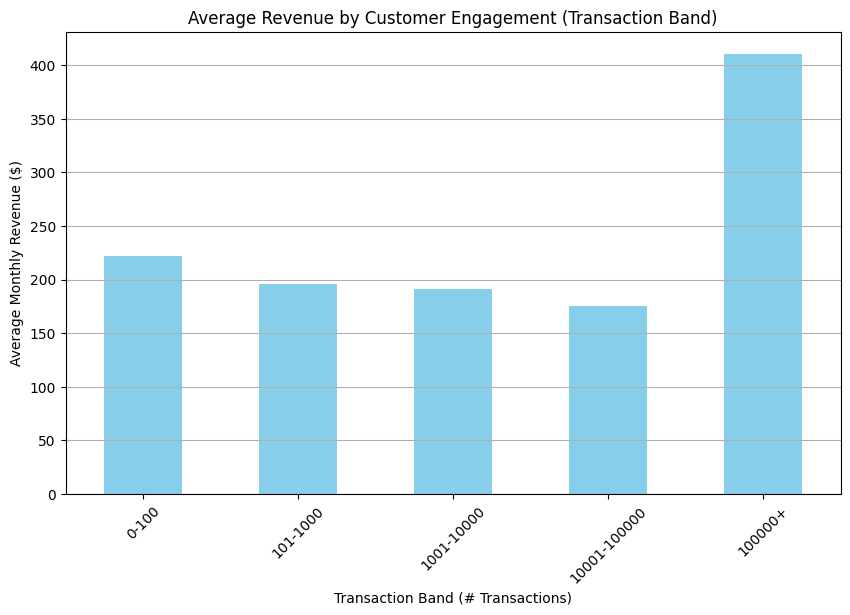

In [ ]:
#############################
#############################    5

######################### Merged code starts here

# Step 1: Prepare the revenue data in a long format
usage_data['Year'] = usage_data['Year'].astype(str)
revenue_data_long = pd.melt(revenue_data, id_vars=['Cust_ID', 'Product Group'], var_name='Year', value_name='Revenue')
revenue_data_long['Year'] = revenue_data_long['Year'].str.extract('(\d{4})')  # Extract the year part

# Step 2: Merge on 'Cust_ID' and 'Year'
merged_data = pd.merge(revenue_data_long, usage_data, on=['Cust_ID', 'Year'], how='inner')

# Step 3: Define numeric transaction bands for clearer ranges
# Creating transaction bands with custom labels for numeric ranges
transaction_bins = [0, 100, 1000, 10000, 100000, merged_data['# Transactions'].max()]
transaction_labels = ['0-100', '101-1000', '1001-10000', '10001-100000', '100000+']

# Apply the custom transaction bands
merged_data['Transaction_Bands'] = pd.cut(merged_data['# Transactions'], bins=transaction_bins, labels=transaction_labels)

# Step 4: Calculate average revenue per transaction band
avg_revenue_per_band = merged_data.groupby('Transaction_Bands')['Revenue'].mean()

# Display the average revenue by transaction band
print("Average Revenue per Transaction Band:")
print(avg_revenue_per_band)

# Step 5: Visualize the relationship with a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
avg_revenue_per_band.plot(kind='bar', color='skyblue')
plt.title('Average Revenue by Customer Engagement (Transaction Band)')
plt.xlabel('Transaction Band (# Transactions)')
plt.ylabel('Average Monthly Revenue ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
# Step 1: Define Engagement Thresholds
# Split customers into low, moderate, and high engagement based on # Transactions
engagement_bins = [0, 100, 1000, merged_data['# Transactions'].max()]
engagement_labels = ['Low Engagement', 'Moderate Engagement', 'High Engagement']

# Apply engagement labels based on thresholds
merged_data['Engagement_Level'] = pd.cut(merged_data['# Transactions'], bins=engagement_bins, labels=engagement_labels)

# Step 2: Calculate Average Revenue for Each Engagement Level
# avg_revenue_by_engagement = merged_data.groupby('Engagement_Level')['Revenue'].mean()

# print("Average Revenue by Engagement Level:")
#print(avg_revenue_by_engagement)

# Step 3: Calculate Churn Rates for Each Engagement Level
# Define a churned customer as having revenue in one year and missing revenue in the following year
merged_data['Churned_Next_Year'] = merged_data['Revenue'].notna() & merged_data.groupby('Cust_ID')['Revenue'].shift(-1).isna()

# Calculate churn rate by engagement level
# churn_rate_by_engagement = merged_data.groupby('Engagement_Level')['Churned_Next_Year'].mean() * 100

# print("Churn Rate by Engagement Level (%):")
# print(churn_rate_by_engagement)





In [ ]:
# Step 1: Focus on early years for engagement data (2021–2023)
early_years = merged_data[merged_data['Year'].isin(['2021', '2022', '2023'])]

# Step 2: Calculate Average Engagement for Each Customer in Early Years
early_engagement = early_years.groupby('Cust_ID')['# Transactions'].mean()
early_engagement = pd.DataFrame(early_engagement).reset_index().rename(columns={'# Transactions': 'Avg_Transactions_Early'})

# Step 3: Merge Early Engagement Data with Churn Information
# Create churn flags for 2024 (churned if revenue in 2023 but missing in 2024)
merged_data['Churned_2024'] = merged_data['Year'] == '2023'
merged_data.loc[merged_data['Churned_2024'], 'Churned_2024'] = merged_data['Revenue'].notna() & merged_data.groupby('Cust_ID')['Revenue'].shift(-1).isna()
churn_data = merged_data[merged_data['Year'] == '2023'][['Cust_ID', 'Churned_2024']]

# Merge churn data with early engagement data
engagement_churn_data = pd.merge(early_engagement, churn_data, on='Cust_ID', how='left')

# Step 4: Analyze Churn Rate by Early Engagement Levels
# Define engagement levels for analysis
engagement_churn_data['Early_Engagement_Level'] = pd.cut(engagement_churn_data['Avg_Transactions_Early'], bins=engagement_bins, labels=engagement_labels)

# Calculate churn rate by early engagement level
early_engagement_churn_rate = engagement_churn_data.groupby('Early_Engagement_Level')['Churned_2024'].mean() * 100

print("Churn Rate by Early Engagement Level:")
print(early_engagement_churn_rate)


Churn Rate by Early Engagement Level:
Early_Engagement_Level
Low Engagement         63.829787
Moderate Engagement    63.178295
High Engagement        64.501579
Name: Churned_2024, dtype: object


<ipython-input-17-63439c402c6e>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  early_engagement_churn_rate = engagement_churn_data.groupby('Early_Engagement_Level')['Churned_2024'].mean() * 100


In [ ]:

#############################
#############################    1

# Assuming 'revenue_data' is in wide format with each year's revenue in separate columns (e.g., '1/2021', '1/2022', etc.)

# Step 1: Reshape revenue_data to have each year as a separate column, then sum by year
# Extract only the revenue columns (e.g., '1/2021', '1/2022', etc.)
yearly_revenue = revenue_data[['1/2021', '1/2022', '1/2023', '1/2024']].sum()

# Convert to DataFrame for easier manipulation
yearly_revenue_df = yearly_revenue.reset_index()
yearly_revenue_df.columns = ['Year', 'Total_Revenue']

# Step 2: Clean up year format if necessary (e.g., remove '1/' prefix)
yearly_revenue_df['Year'] = yearly_revenue_df['Year'].str.extract('(\d{4})')  # Extract year part only
yearly_revenue_df['Year'] = yearly_revenue_df['Year'].astype(int)

# Display the total revenue for each year
print("Year-on-Year Revenue:")
print(yearly_revenue_df)


Year-on-Year Revenue:
   Year  Total_Revenue
0  2021      1082925.0
1  2022      1180969.0
2  2023      1330702.0
3  2024      1505090.0


Revenue by Year and Product:
    Year     Product Group    Revenue
0   2021       FraudFinder   503215.0
1   2021  FraudFinder 2.0.   543510.0
2   2021             Other    36200.0
3   2022       FraudFinder   432912.0
4   2022  FraudFinder 2.0.   681381.0
5   2022             Other    66676.0
6   2023       FraudFinder   316154.0
7   2023  FraudFinder 2.0.   925815.0
8   2023             Other    88733.0
9   2024       FraudFinder   267388.0
10  2024  FraudFinder 2.0.  1081437.0
11  2024             Other   156265.0


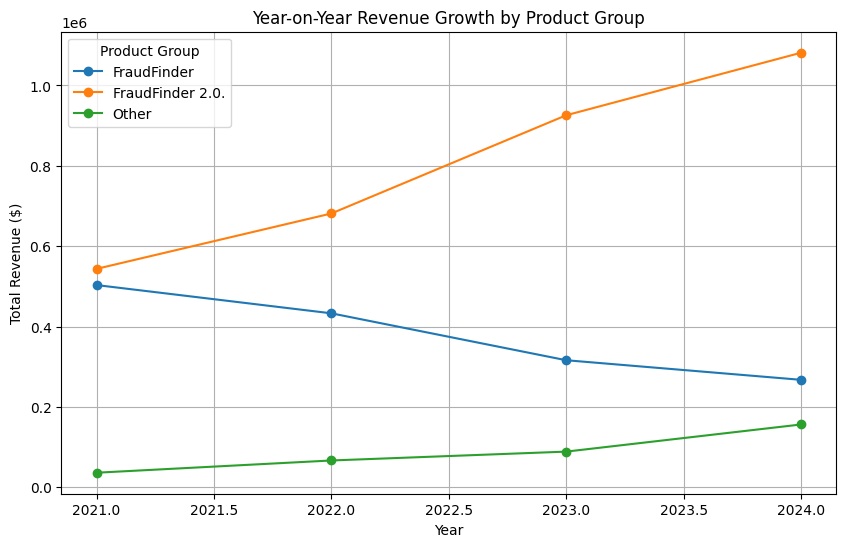

In [ ]:
#############################
#############################    1

# Step 1: Reshape the data into long format if necessary
# Assuming revenue_data is in wide format with each year's revenue in separate columns
# Convert it to long format to have 'Year' and 'Revenue' columns for easier grouping

# Melt the data to have a 'Year' column and a 'Revenue' column
revenue_data_long = pd.melt(revenue_data, id_vars=['Cust_ID', 'Product Group'],
                            value_vars=['1/2021', '1/2022', '1/2023', '1/2024'],
                            var_name='Year', value_name='Revenue')

# Extract year as an integer for easier manipulation
revenue_data_long['Year'] = revenue_data_long['Year'].str.extract('(\d{4})').astype(int)

# Step 2: Calculate total revenue by Year and Product Group
revenue_by_year_product = revenue_data_long.groupby(['Year', 'Product Group'])['Revenue'].sum().reset_index()

# Display the total revenue by year and product
print("Revenue by Year and Product:")
print(revenue_by_year_product)

import matplotlib.pyplot as plt

# Assuming 'revenue_by_year_product' contains the total revenue for each year and product group

# Plotting Year-on-Year Revenue Growth by Product Group
plt.figure(figsize=(10, 6))

# Iterate over each product group to plot separately
for product in revenue_by_year_product['Product Group'].unique():
    product_data = revenue_by_year_product[revenue_by_year_product['Product Group'] == product]
    plt.plot(product_data['Year'], product_data['Revenue'], marker='o', label=product)

# Customize plot
plt.title('Year-on-Year Revenue Growth by Product Group')
plt.xlabel('Year')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product Group')
plt.grid(True)

# Show plot
plt.show()


<ipython-input-21-0b121f7a5654>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Revenue_Segment'] = pd.cut(filtered_data['Revenue'], bins=[0, revenue_threshold, filtered_data['Revenue'].max()], labels=['Low Revenue', 'High Revenue'])
<ipython-input-21-0b121f7a5654>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Usage_Segment'] = pd.cut(filtered_data['# Transactions'], bins=[0, transaction_threshold, filtered_data['# Transactions'].max()], labels=['Low Usage', 'High Usage']

Customer Segment Counts:
Customer_Segment
High Revenue / High Usage     302
High Revenue / Low Usage      317
Low Revenue / High Usage      283
Low Revenue / Low Usage      1334
Name: Cust_ID, dtype: int64


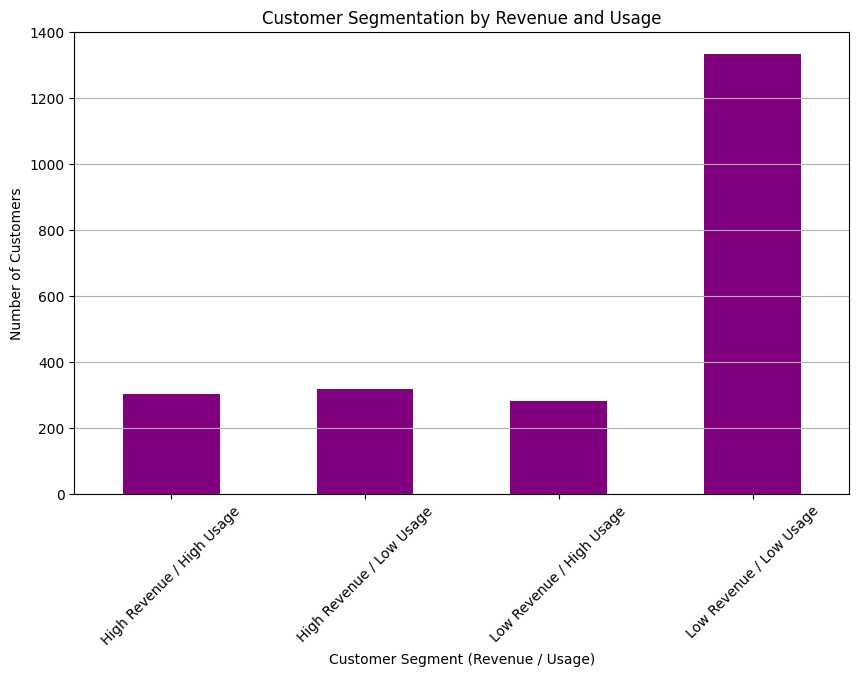

In [ ]:
#############################
#############################    4


# Step 1: Exclude rows with NaN values in either Revenue or # Transactions
filtered_data = merged_data.dropna(subset=['Revenue', '# Transactions'])

# Step 2: Define thresholds for high and low revenue and usage based on quartiles or specific values
revenue_threshold = filtered_data['Revenue'].quantile(0.75)  # Example: top 25% as high revenue
transaction_threshold = filtered_data['# Transactions'].quantile(0.75)  # Example: top 25% as high usage

# Step 3: Classify each customer by revenue and transaction volume
filtered_data['Revenue_Segment'] = pd.cut(filtered_data['Revenue'], bins=[0, revenue_threshold, filtered_data['Revenue'].max()], labels=['Low Revenue', 'High Revenue'])
filtered_data['Usage_Segment'] = pd.cut(filtered_data['# Transactions'], bins=[0, transaction_threshold, filtered_data['# Transactions'].max()], labels=['Low Usage', 'High Usage'])

# Step 4: Combine Revenue and Usage Segments to create Customer Segments
filtered_data['Customer_Segment'] = filtered_data['Revenue_Segment'].astype(str) + ' / ' + filtered_data['Usage_Segment'].astype(str)

# Calculate the number of customers in each segment
customer_segment_counts = filtered_data.groupby('Customer_Segment')['Cust_ID'].nunique()

print("Customer Segment Counts:")
print(customer_segment_counts)

# Visualize customer segments
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
customer_segment_counts.plot(kind='bar', color='purple')
plt.title('Customer Segmentation by Revenue and Usage')
plt.xlabel('Customer Segment (Revenue / Usage)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
